# House Prices

Initilize project files and libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

data: pd.DataFrame = pd.read_csv("data/train.csv")
test: pd.DataFrame = pd.read_csv("data/test.csv")
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Process data

In [2]:
IdColumn = test[['Id']]          # Save Id column
data = data.drop(columns=['Id']) # We don't need Id for calculations
test = test.drop(columns=['Id'])
data.shape

(1460, 80)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

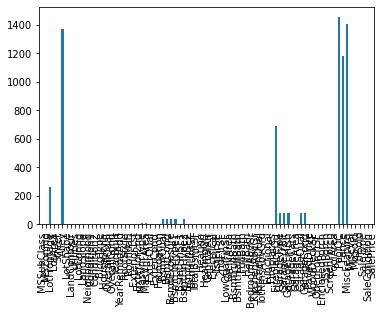

In [4]:
nulls = data.isnull().sum()

ax = nulls.plot.bar()

We can see, that some of the collums are mostly filled with null values.

I will drop the collums that have more than 50% of the values set to null, and changing other collumns' null values either with mean (for numeric data) or mode (for objets)

In [5]:
def handleNullValues(data: pd.DataFrame) -> pd.DataFrame:
    for column in data.columns:
        if data[column].isnull().sum() == 0:
            continue                                                       # No problem with the data, no modification

        elif data[column].isnull().sum() >= data.shape[0] / 2:
            data = data.drop(columns=[column])                             # At least 50% of the data is undefined 

        elif data[column].dtype != np.object_:
            data[column] = data[column].fillna(data[column].mean())        # Numerical types

        else:
            data[column] = data[column].fillna(data[column].mode()[0])     # Object types

    return data

(1460, 76)

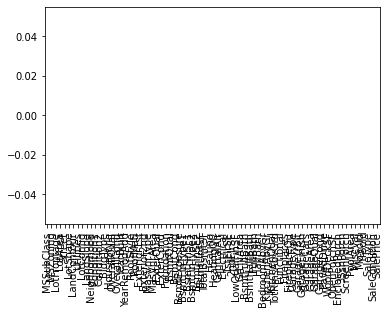

In [6]:
data = handleNullValues(data)
test = handleNullValues(test)

ax = data.isnull().sum().plot.bar()
data.shape

Null values are completely gone.

Now we need to change non-numerical values into numericals using hot_one_encoding

In [7]:
def oneHotEncoder(data: pd.DataFrame) -> pd.DataFrame:
    data_copy: pd.DataFrame = data                                  # We do not want to change data while iterating over it

    for column in data.columns:
        if data[column].dtype != np.object_:
            continue

        dummy = pd.get_dummies(data[column], drop_first=True)

        data_copy = data_copy.drop([column], axis=1)                # We don't need non-numeric column any more
        data_copy = pd.concat([data_copy, dummy], axis=1)       

    data = data_copy
    
    return data

In [8]:
data = oneHotEncoder(data)
test = oneHotEncoder(test)

data = data.loc[:, ~data.columns.duplicated()]      # Remove duplicate collumns
test = test.iloc[:, ~test.columns.duplicated()]

In [9]:
data.info()
data.shape, test.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 177 entries, MSSubClass to Partial
dtypes: float64(3), int64(34), uint8(140)
memory usage: 621.8 KB


((1460, 177), (1459, 166))

train and test datas do not have the same amount of columns.

We need to drop the extra columns from test data and add columns with the value of 0 from train data to test data.

In [10]:
def modifyTestCollumns(train: pd.DataFrame, test: pd.DataFrame) -> pd.DataFrame:              
    test_copy = test                                                 # We should not change the data while iterating over them

    for testColumn in test:
        if testColumn not in train.columns:
            test_copy = test_copy.drop(columns=[testColumn])        # Remove extra columns

    for trainColumn in train:
        if trainColumn not in test and trainColumn != 'SalePrice':  # Test data does not need target column
            test_copy[trainColumn] = 0                              # Add missing columns with the value of 0

    test_sorted = pd.DataFrame()                                    # Sort test columns like train data
    for trainColumn in train:
        if trainColumn != 'SalePrice':
            test_sorted = pd.concat([test_sorted, test_copy[[trainColumn]]], axis=1)

    test = test_sorted

    return test    

In [11]:
test = modifyTestCollumns(data, test)
data.shape, test.shape

((1460, 177), (1459, 176))

all non-nmerical data is gone and the data is ready to be passed to ML model.

### finish up preprocessing and extract information for ML Models

In [12]:
y: pd.DataFrame = data[['SalePrice']]       # SalePrice is our targer variableX: pd.DataFrame = data.iloc[:, 0:-1] # Train data

X: pd.DataFrame = data.drop(columns=['SalePrice'])
X = (X - X.mean()) / X.std()                # Feature scaling

test = (test - test.mean()) / test.std()
test = test.fillna(0)                       # For columns with only 0 values, test.std() is zero, so the values become NaN. Se need to replace them with 0

X.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,ConLI,ConLw,New,Oth,WD,AdjLand,Alloca,Family,Normal,Partial
0,0.073350,-0.229293,-0.207071,0.651256,-0.517023,1.050634,0.878367,0.511243,0.575228,-0.288554,...,-0.058601,-0.058601,-0.301858,-0.045361,0.390159,-0.052396,-0.091003,-0.117811,0.467491,-0.30589
1,-0.872264,0.451781,-0.091855,-0.071812,2.178881,0.156680,-0.429430,-0.574214,1.171591,-0.288554,...,-0.058601,-0.058601,-0.301858,-0.045361,0.390159,-0.052396,-0.091003,-0.117811,0.467491,-0.30589
2,0.073350,-0.093078,0.073455,0.651256,-0.517023,0.984415,0.829930,0.322950,0.092875,-0.288554,...,-0.058601,-0.058601,-0.301858,-0.045361,0.390159,-0.052396,-0.091003,-0.117811,0.467491,-0.30589
3,0.309753,-0.456318,-0.096864,0.651256,-0.517023,-1.862993,-0.720051,-0.574214,-0.499103,-0.288554,...,-0.058601,-0.058601,-0.301858,-0.045361,0.390159,-0.052396,-0.091003,-0.117811,-2.137613,-0.30589
4,0.073350,0.633401,0.375020,1.374324,-0.517023,0.951306,0.733056,1.364102,0.463410,-0.288554,...,-0.058601,-0.058601,-0.301858,-0.045361,0.390159,-0.052396,-0.091003,-0.117811,0.467491,-0.30589


In [13]:
test.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,ConLI,ConLw,New,Oth,WD,AdjLand,Alloca,Family,Normal,Partial
0,-0.874411,0.555397,0.363804,-0.750844,0.400629,-0.340828,-1.072517,-0.569913,0.063273,0.517171,...,-0.052414,-0.045377,-0.295167,-0.052414,0.398431,-0.074227,-0.091035,-0.134653,0.460053,-0.299262
1,-0.874411,0.604032,0.897553,-0.054858,0.400629,-0.439544,-1.214492,0.041259,1.063027,-0.297800,...,-0.052414,-0.045377,-0.295167,-0.052414,0.398431,-0.074227,-0.091035,-0.134653,0.460053,-0.299262
2,0.061330,0.263586,0.809368,-0.750844,-0.497247,0.843770,0.678509,-0.569913,0.772989,-0.297800,...,-0.052414,-0.045377,-0.295167,-0.052414,0.398431,-0.074227,-0.091035,-0.134653,0.460053,-0.299262
3,0.061330,0.458126,0.032053,-0.054858,0.400629,0.876675,0.678509,-0.456733,0.357706,-0.297800,...,-0.052414,-0.045377,-0.295167,-0.052414,0.398431,-0.074227,-0.091035,-0.134653,0.460053,-0.299262
4,1.464941,-1.244106,-0.971475,1.337113,-0.497247,0.679242,0.394559,-0.569913,-0.387166,-0.297800,...,-0.052414,-0.045377,-0.295167,-0.052414,0.398431,-0.074227,-0.091035,-0.134653,0.460053,-0.299262


change data to matrices for easy mathematical operations in ML models

In [14]:
X = np.matrix(X.values)
y = np.matrix(y.values)
testX = np.matrix(test.values)

X.shape, y.shape

((1460, 176), (1460, 1))

# Start Creating ML Model

### Define some useful functions for modeling

define linear regression cost function

In [15]:
def linearRegCost(X: np.matrix, y: np.matrix, theta: np.matrix, addOnes: bool = True) -> np.float64:
    if addOnes:
        X = np.insert(X, 0, values=np.ones(X.shape[0]), axis=1)

    return np.sum(np.square(X * theta.T - y)) / (2 * X.shape[0])

define gradient descent function

In [16]:
def gradientDescent(X: np.matrix, y: np.matrix, alpha: float, iters: int) -> tuple[np.matrix, np.ndarray]:
    X = np.insert(X, 0, values=np.ones(X.shape[0]), axis=1)
    theta = np.matrix(np.zeros(X.shape[1]))
    cost = np.zeros(iters)

    for i in range(iters):
        theta = theta - alpha * (X.T * (X * theta.T - y)).T / X.shape[0]
        cost[i] = linearRegCost(X, y, theta, addOnes=False)

        if i > 0 and cost[i - 1] - cost[i] < 0.001:       # declare convergence
            break 

    return theta, cost  # return cost for debugging

# Test Model

In [17]:
iters = 5000
alpha = 0.1
theta, cost = gradientDescent(X, y, alpha, iters)

linearRegCost(X, y, theta)      # optimal cost found at 5000 iterations and 0.1 alpha

283025063.28648204

Text(0.5, 1.0, 'Error vs. Training Epoch')

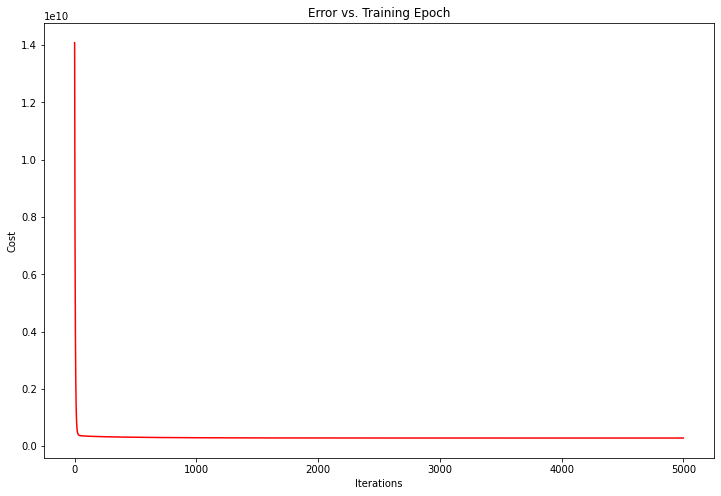

In [18]:
vfig, ax = plt.subplots(figsize=(12,8))
ax.plot(np.arange(iters), cost, 'r')
ax.set_xlabel('Iterations')
ax.set_ylabel('Cost')
ax.set_title('Error vs. Training Epoch')

linear regression algorithm works correctly

In [24]:
test_with_ones = np.insert(testX, 0, np.ones(testX.shape[0]), axis=1)
pred = test_with_ones * theta.T
result = pd.DataFrame(pred, columns=['SalePrice'])
result = pd.concat([IdColumn, result], axis=1)

result.head()
result.to_csv('data/result.csv', index=False)